In [1]:
import matplotlib.pyplot as plt
import numpy as np
from trafficintelligence import events, moving
import network
import simulation
import toolkit
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol

OpenCV library could not be loaded (video replay functions will not be available)
OpenCV library could not be loaded (video replay functions will not be available)


In [2]:
def timeToCollisionAtInstant(user, t):
    if user.leader is not None:
        leader = user.leader
        x0 = leader.getCurvilinearPositionAtInstant(t)[0]
        v0 = leader.getCurvilinearVelocityAtInstant(t)[0]
        x1 = user.getCurvilinearPositionAtInstant(t)[0]
        v1 = user.getCurvilinearVelocityAtInstant(t)[0]
        if v1 > v0:
            ttc = (x0 - x1 - leader.geometry) / (v1 - v0)
            return ttc
    else:
        return None

def timeToCollision(user):
    ttc = []
    if user.leader is not None:
        inter = moving.TimeInterval.intersection(user.timeInterval, user.leader.timeInterval)
        for t in list(inter):
            if timeToCollisionAtInstant(user, t) is not None:
                ttc.append(timeToCollisionAtInstant(user, t))
    return ttc

In [5]:
def evaluateModel(paramSet, world, sim):
    world.userInputs[0].distributions['dn'].degeneratedConstant = paramSet[0]
    world.userInputs[0].distributions['headway'].degeneratedConstant = paramSet[1]
    world.userInputs[0].distributions['length'].degeneratedConstant = paramSet[2]
    world.userInputs[0].distributions['speed'].degeneratedConstant = paramSet[3]
    world.userInputs[0].distributions['tau'].degeneratedConstant = paramSet[4]
    seeds = [5]
    headways = [paramSet[1]]
    
    interactions = {}
    usersCount = {}
    
    for seed in seeds:
        usersCount[seed] = {}
        interactions[seed] = {}
        sim.seed = seed

        for h in headways:
            interactions[seed][h] = {}
            world = sim.run(world)
            usersCount[seed][h] = world.getNotNoneVehiclesInWorld()[0]
            
            for userNum in range(len(usersCount[seed][h]) - 1):
                roadUser1 = world.getUserByNum(userNum)
                roadUser2 = world.getUserByNum(userNum + 1)
#                 print(len(roadUser1.curvilinearVelocities), len(roadUser2.curvilinearVelocities))
                interactions[seed][h][(roadUser1.num, roadUser2.num)] = []
                i = events.Interaction(useCurvilinear=True, roadUser1=roadUser1, roadUser2=roadUser2)
                i.computeIndicators(world=world, alignment1=world.travelledAlignments(roadUser1), alignment2=world.travelledAlignments(roadUser2))

                interactions[seed][h][(roadUser1.num, roadUser2.num)].append(i)
    TTC = {}
    TTCmin = {}

    simulatedUsers = world.getNotNoneVehiclesInWorld()[0]
    for user in simulatedUsers:
        ttc = timeToCollision(user)
        user0 = user.leader
        if user0 is None:
            num0 = None
        else:
            num0 = user0.num
            
        TTC[num0, user.num] = ttc
        if ttc != []:
            TTCmin[num0, user.num] = min(TTC[num0, user.num])   
            
    n, bins = np.histogram(list(TTCmin.values()))
    mids = 0.5*(bins[1:] + bins[:-1])
    mean = np.average(mids, weights=n)
    return mean

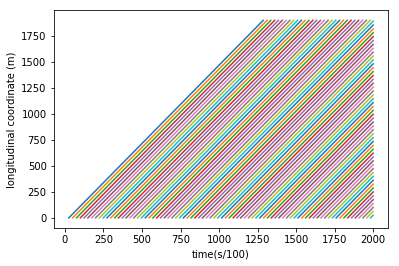

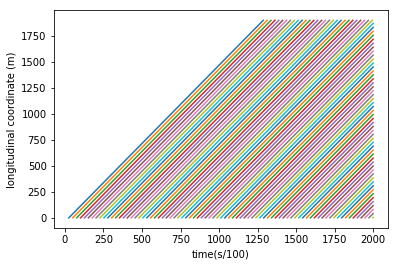

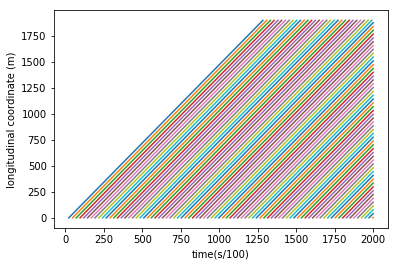

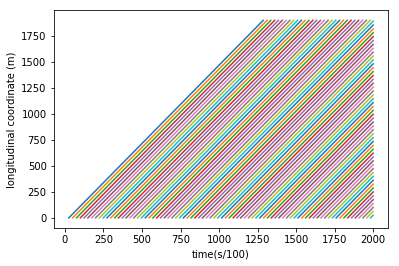

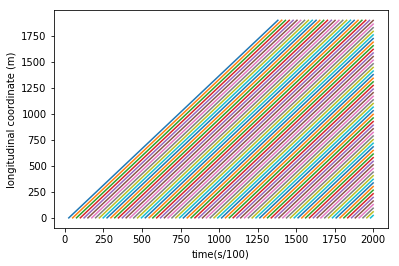

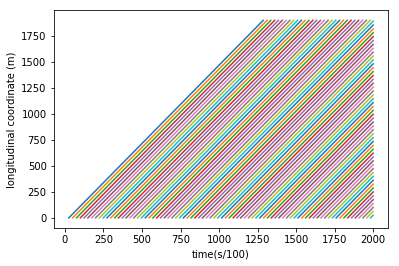

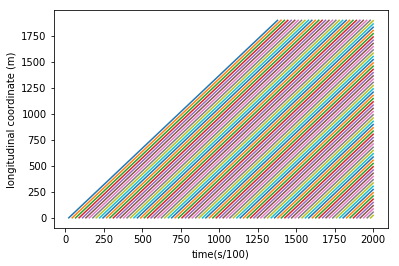

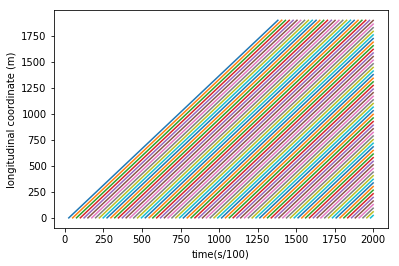

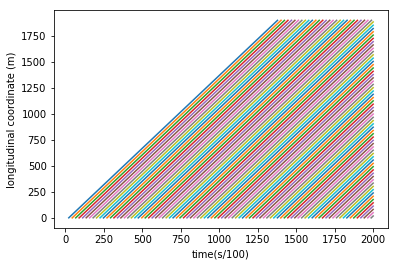

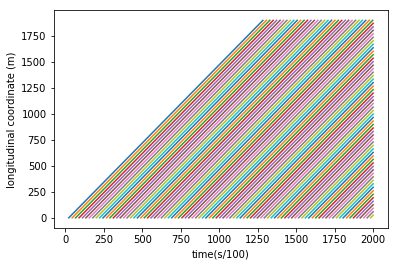

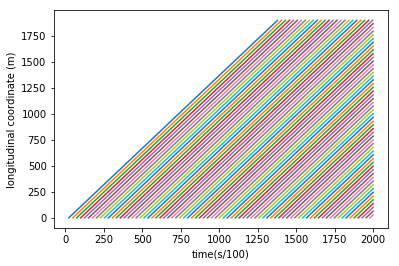

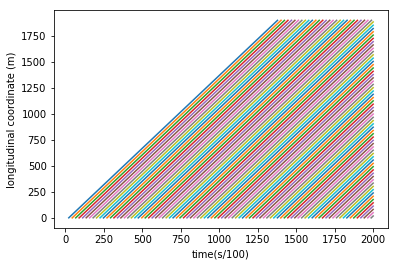

In [8]:
problem = {
    'num_vars': 5,
    'names': ['d', 'headway', 'length', 'speed', 'tau'],
    'bounds': [[7.33, 9.33],
           [2.0001633772214027, 6.936204757259126],
           [6, 8],
           [11, 17],
           [1.5, 3]
          ]
#     'bounds': [[4.8092326361444, 11.70133510253817],
#                [2.0001633772214027, 6.936204757259126],
#                [5.5, 8.5],
#                [3.4298137357322904, 24.128876621167606],
#                [0.2529013270535836, 3.6828749942130656]
#               ]
}
# paramValues = np.array([[ 8.01945313,  4.07773548,  6.28710938, 12.81054688,  1.73291016]])
paramValues = saltelli.sample(problem, 1)
Y = np.zeros([paramValues.shape[0]])

for i, X in enumerate(paramValues):
    world = network.World.load('simple-net.yml')
    sim = simulation.Simulation.load('config.yml')
    Y[i] = evaluateModel(X, world, sim)


In [9]:
Si = sobol.analyze(problem, Y, print_to_console=True)
toolkit.callWhenDone()

Parameter S1 S1_conf ST ST_conf
d 2.108222 0.000000 1.863526 0.000000
headway 1.229564 0.000000 0.633877 0.000000
length 0.061646 0.000000 0.001593 0.000000
speed 0.371376 0.000000 0.057827 0.000000
tau 0.000000 0.000000 0.000000 0.000000

Parameter_1 Parameter_2 S2 S2_conf
d headway -2.434049 0.000000
d length -0.835369 0.000000
d speed -1.259336 0.000000
d tau -0.750986 0.000000
headway length 0.139258 0.000000
headway speed -0.316675 0.000000
headway tau 0.230003 0.000000
length speed -0.057221 0.000000
length tau -0.054571 0.000000
speed tau 0.888906 0.000000


In [27]:
Si['ST']

array([1.86352568e+00, 6.33877172e-01, 1.59335235e-03, 5.78269986e-02,
       0.00000000e+00])